In [1]:
print('hi')

hi


## Import Section

In [2]:
import numpy as np
import torch
import torchvision
from time import time
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.autograd import Variable
import os
import glob
import cv2
from tqdm import tqdm

from matplotlib.pyplot import imsave, imread
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec

import copy
import pickle

In [3]:
from floodfill import *
from dataloader import *
from model import *
from oracle import *
from unet import *
import ternausnet.models

In [4]:
from vivek.model import *

## Testing Jupyter Notebook Section

In [5]:
#Testing live input from user
testing_input = input("what is your name: ")
print(f"Your name is: {testing_input}.")

what is your name: vaibhav
Your name is: vaibhav.


(2, 256, 256)


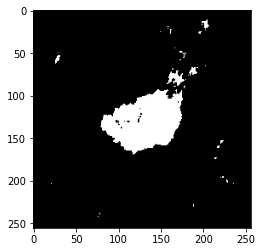

In [6]:
#Tests loading an image from a directory
im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations/train/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/UNetSegmentations/Iter0_ff/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter2/UNetSegmentations_C/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter2/UNetSegmentations_C/Round/"
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_24_b/Iter1/UNetSegmentations_C/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/UNetSegmentations/Iter0_ff/Round/"
ims = ["DP_ACRF_18645_1.npy"]
#ims = ["DP_AGCQ_94785_1.npy"]

for im in ims:
    path = im_dir + im;
    arr = np.load(path)
    print(arr.shape)
    
plt.imshow(arr[1],cmap='gray')
#plt.show()

## Active Learning: Setup - Run once per run id

In [7]:
run_id = "12_19_b" #Format: Month_Day_(Run # that day by letter)
# run_id = "11_30_a"
#original 

In [8]:
iter_num=1

In [9]:
#Gets the dataloader. Passes in directory of ALL images
#im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations/train/"
#GET THE NEW IM_DIR FOR SUBSEQUENT ITERATIONS
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/UNetSegmentations/Iter0_ff/"
dataloader = get_DataLoader(im_dir,32,2)

#Tests the dataloader
for i in tqdm(dataloader):
    #print(i[1])
    print(i[1].shape)
    break

  0%|          | 0/26 [00:00<?, ?it/s]

torch.Size([32, 1, 256, 256])


  0%|          | 0/26 [00:09<?, ?it/s]


In [11]:
#Initializing info arrays for active learning
oracle_results = {}

## Active Learning: Querying

Using cache found in /home/users/vs196/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


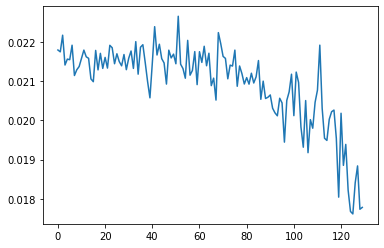

In [10]:
#Initializes and trains the model. Plots a loss function of the initial training
model,loss_tracker,criterion,optimizer = initialize_and_train_model(dataloader, epochs=5) #default batch_size and epochs
plt.plot(loss_tracker) #plot graph

In [11]:
all_patient_scores = []

#right now patient_scores is initial scores for each patient (without active learning training)
patient_scores = get_patient_scores(model,dataloader) 
all_patient_scores.append(patient_scores)

100%|██████████| 26/26 [00:05<00:00,  4.63it/s]


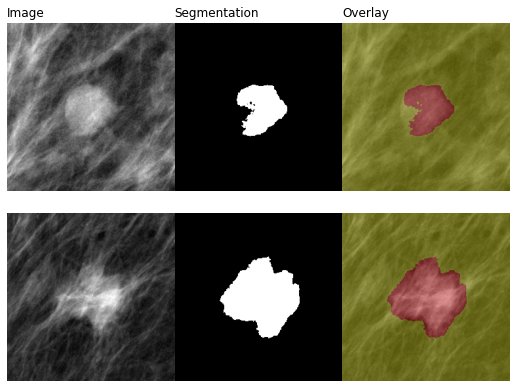

If any part of an image segmentation is incorrect, label the entire image as incorrect.
Enter labels for images per row without separation. 1 is a good label, 0 is a bad label. 2 is skip: 000001000


In [43]:
#query oracle
new_oracle_results = query_oracle(oracle_results,patient_scores,im_dir,query_method="percentile=0.7",query_number=10)
oracle_results = new_oracle_results

In [73]:
#
#TODO: track model loss somehow along with patient_scores
#Query oracle and update model via active learning
for i in range(5):
    model = model_update(model,dataloader,oracle_results,criterion,optimizer,num_epochs=1)

    patient_scores = get_patient_scores(model,dataloader)
    all_patient_scores.append(patient_scores)

100%|██████████| 26/26 [00:05<00:00,  4.97it/s]


## Metrics and plotting

In [74]:
#Prints out all patient scores.
for i in all_patient_scores:
    print(calculate_dispersion_metric(i,oracle_results))

0.5531475748194015
0.554437564499484
0.576109391124871
0.6065531475748194
0.6537667698658411
0.6787925696594428
0.650670794633643
0.7801857585139319
0.7205882352941176
0.750515995872033
0.8157894736842105
0.8446852425180599
0.8384932920536636
0.8645510835913313
0.8459752321981424
0.8124355005159959
0.8849329205366357
0.8823529411764706
0.8699690402476781
0.8759029927760578
0.901186790505676
0.8648090815273478
0.9050567595459236
0.9171826625386997
0.9512383900928792
0.9494324045407637


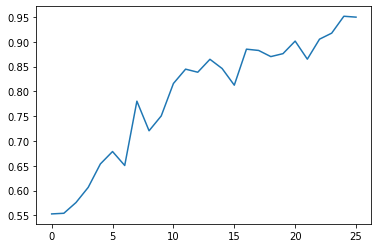

In [75]:
#Plot the disperson metric
j = []
for i in all_patient_scores:
    j.append(calculate_dispersion_metric(i,oracle_results))
    
plt.plot(j)

Length of patient scores: 824
Length of oracle results: 148
Number of ones in oracle results:  34


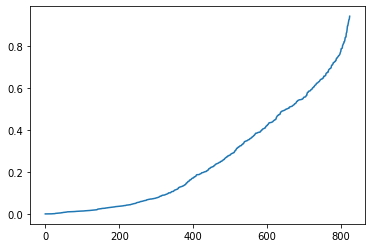

In [76]:
print("Length of patient scores: " + str(len(patient_scores)))
print("Length of oracle results: " + str(len(oracle_results)))

scores = []
for key in patient_scores.keys():
    scores.append(patient_scores[key])
plt.plot(scores)

ones = 0
for i in oracle_results.keys():
    if oracle_results[i]==1:
        ones+=1
print("Number of ones in oracle results: ", ones)

Jump back to oracle query if you want to query more. Move on to retrain segmenter

## Saving Oracle Results

In [77]:
#make filepath
save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
saved_oracle_filepaths = save_oracle_results(oracle_results,im_dir,save_dir)
fpath = save_dir + "saved_data_struct/"
if not os.path.exists(fpath):
    os.makedirs(fpath)
saved_oracle_filepaths_filepath = save_dir + "saved_data_struct/Oracle_Filepaths.pickle"
pickle.dump(saved_oracle_filepaths,open(saved_oracle_filepaths_filepath,"wb"))
pickle.dump(oracle_results,open(save_dir + "saved_data_struct/Oracle_Results.pickle","wb"))
#TODO: Move border/weight creation to this method and out of convert_directory_to_floodfill

Done with saving this iteration of oracle results


In [78]:
#Reloading oracle_results and save_oracle_filepaths
save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
saved_oracle_filepaths_filepath = save_dir + "saved_data_struct/Oracle_Filepaths.pickle"
#Reload from previous iteration
oracle_results = pickle.load(open(save_dir + "saved_data_struct/Oracle_Results.pickle","rb"))
saved_oracle_filepaths = pickle.load(open(saved_oracle_filepaths_filepath,"rb"))

In [14]:
#Remove all 0's from oracle_results.
oracle_results = remove_bad_oracle_results(oracle_results)
#NOTE: Don't FULLY reset oracle_results EVER during a run, only do above

In [15]:
print(len(oracle_results))

37


## Retrain UNet and Save New Segmentations

In [ ]:
from_scratch = True
#Define the initial UNet model (iter0)
if iter_num==1:
    model_path = "/usr/xtmp/vs196/mammoproj/SavedModels/HyperparameterUNet_nobuffer/unet_5_0.5/Model/unetmodel_FINAL.pth"
else:
    model_path = model_save_path
    
if not from_scratch:
    unet_model = torch.load(model_path)
else:
    unet_model = getattr(ternausnet.models, "UNet16")(num_classes=2,pretrained=True).cuda()

total_loss_tracker = []
total_metric_tracker = []

In [ ]:
#Retrain UNet with training data taken from OracleImages/Iter
new_unet_dataloader = unet_dataloader(saved_oracle_filepaths,8,2)
cbis_trainloader,_ = CBIS_DDSM_get_DataLoader(8,2)

#unet_model,loss_tracker,metric_tracker = unet_update_model(unet_model,cbis_trainloader,num_epochs=15)
unet_model,loss_tracker,metric_tracker = unet_update_model_multi_dataloader(unet_model,new_unet_dataloader,cbis_trainloader,num_epochs=10)
total_loss_tracker.extend(loss_tracker)
total_metric_tracker.extend(metric_tracker)

In [ ]:
#plt.plot(total_loss_tracker)
plt.plot(total_metric_tracker)

In [ ]:
#evaluate new segmentations for ALL images 
#Save SAVED_ORACLE_FILEPATH NEW segmentations to SEPARATE FOLDER for VIEWING ONLY
#Save this iteration saved_oracle_filepaths along with new segmentations for all other patients
segmentation_folder = im_dir
correct_save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations_C/"
save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations/"
#Method creates new segmentations using updated model. 
#Saves new segmentations for images labelled correctly by the oracle to correct_save_dir
#Saves all segmentations (preserved for images labelled correctly by the oracle, new for all others) to save_dir
#Have different subfolders for different iterations of unet update
evaluate_model_on_new_segmentations_and_save(unet_model,segmentation_folder,saved_oracle_filepaths,correct_save_dir,save_dir,iter_num)

#save the model
model_save_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/unetmodel.pth"
torch.save(unet_model,model_save_path)

#save_dir is what we convert to floodfill two cells down.
#TODO: ADD TQDM TO EVALUATE_MODEL...

In [ ]:
#Convert initial UNet Segmentations to flood-filled and resave
#raw_segmentation_folder = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations/train/"
raw_segmentation_folder = save_dir #remove for rerun
im_dir = convert_directory_to_floodfill(raw_segmentation_folder,iter0=False)

In [ ]:
iter_num+=1

In [ ]:
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter1/UNetSegmentations_ff/"

In [ ]:
#reloading iter 1 purposes
iter_num = 2
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_23_a/Iter1/UNetSegmentations_ff/"
dataloader = get_DataLoader(im_dir,32,2)

In [ ]:
print(iter_num)
print(model_save_path)

In [ ]:
print(im_dir)

# Saving Images for Fides

In [97]:
print(exclude_patientIDs)

{'DP_ALEX_27292_1', 'DP_AANM_5811_1', 'DP_ACYT_22717_1', 'DP_AGAU_93007_1', 'DP_AHSU_130157_1', 'DP_AGSO_108513_2', 'DP_AKSE_14976_1', 'DP_ACKV_16082_1', 'DP_AIDZ_140011_1', 'DP_AGYA_113298_1', 'DP_AERR_47679_1', 'DP_ADQQ_30947_1', 'DP_AERR_47680_1', 'DP_AIEP_140492_1', 'DP_ABIF_169242_1', 'DP_ABYY_11777_1', 'DP_ALDY_26335_1', 'DP_AJEQ_186744_1', 'DP_ADIC_26895_3', 'DP_AEWN_51567_1', 'DP_AFUQ_74063_1', 'DP_AHUJ_131052_1', 'DP_AKXN_20679_1', 'DP_AGFV_98144_1', 'DP_AAIG_4059_1', 'DP_AAYT_160711_1', 'DP_AJHY_189730_1', 'DP_ADVC_33157_1', 'DP_AJTT_82942_1', 'DP_AFSR_72217_1', 'DP_AAMJ_5544_1', 'DP_ABAS_162674_1', 'DP_AJUZ_84243_1', 'DP_ADQD_27965_1', 'DP_AKOO_11843_1', 'DP_ADWF_33713_1', 'DP_AGFO_97984_1'}


In [98]:
def display_image_annotation(filepath,annotations):
    ncols, nrows = 3, len(filepath)
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(9, 3*len(filepath)+1)
    fig.tight_layout()
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,hspace=0,wspace=0)
    
    anno_opts = dict(xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left',color='cyan',fontweight='extra bold',fontsize='8')

    f_axes = []
    for row in range(nrows):
        f_axes.append([])
        for col in range(ncols):
            f_axes[-1].append(fig.add_subplot(spec[row, col]))

    for ax_num, ax in enumerate(f_axes[0]):
            if ax_num == 0:
                ax.set_title("Image", fontdict=None, loc='left', color = "k")
            elif ax_num == 1:
                ax.set_title("Segmentation", fontdict=None, loc='left', color = "k")
            elif ax_num == 2:
                ax.set_title("Overlay", fontdict=None, loc='left', color = "k")

    for row in range(nrows):
        image_and_mask = np.load(filepath[row])
        f_axes[row][0].imshow(image_and_mask[0],cmap='gray')
        f_axes[row][0].set_axis_off()
        
        f_axes[row][1].imshow(image_and_mask[1],cmap='gray')
        f_axes[row][1].set_axis_off()

        heatmap = cv2.applyColorMap(np.uint8(255*(1-image_and_mask[1])), cv2.COLORMAP_AUTUMN)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]

        img = 0.6 * np.stack([image_and_mask[0],image_and_mask[0],image_and_mask[0]],axis=-1) + 0.3*heatmap
        f_axes[row][2].imshow(img)
        f_axes[row][2].set_axis_off()
        
        f_axes[row][0].annotate(annotations[row],**anno_opts)

    #plt.show()

In [99]:
tobechecked_save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/ToBeChecked/"

exclude_data_from_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_30_a/Iter1/CorrectSegmentations/"
already_sent_oracle_filepaths = pickle.load(open(exclude_data_from_dir + "saved_data_struct/" + "Oracle_Filepaths.pickle",'rb'))
exclude_patientIDs = set()
for already_sent_oracle_filepath in already_sent_oracle_filepaths:
    pat_ID = already_sent_oracle_filepath.split('/')[-1][:-4]
    exclude_patientIDs.add(pat_ID)

In [100]:
for save_filepath in saved_oracle_filepaths:
    #plot the 3 part image as in oracle query
    annotation = '/'.join((save_filepath.split('/'))[-2:])
    pat_ID = save_filepath.split('/')[-1][:-4]
    if pat_ID in exclude_patientIDs:
        print(f'collision for {pat_ID}')
    else:
        display_image_annotation([save_filepath],[annotation])

        #put an annotation on that image with the patient ID and the class
        #save the image in tobechecked_save_dir
        tobechecked_save_subfolder = os.path.join(tobechecked_save_dir ,save_filepath.split('/')[-2]) + "/"
        if not os.path.exists(tobechecked_save_subfolder):
            os.makedirs(tobechecked_save_subfolder)
        save_path = os.path.join(tobechecked_save_dir, annotation)[:-4]+".png"
        plt.savefig(save_path)
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


collision for DP_ADVC_33157_1


In [101]:
print(tobechecked_save_dir)

/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_12_19_b/Iter1/ToBeChecked/


# Vivek GAN stuff

In [36]:
#Vivek GAN Playground
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
#from models import G, D, weights_init (Already imported)
#from data import get_training_set, get_test_set
import torch.backends.cudnn as cudnn

#Retrain UNet with training data taken from OracleImages/Iter
new_unet_dataloader = unet_dataloader(saved_oracle_filepaths,8,2)
#cbis_trainloader,_ = CBIS_DDSM_get_DataLoader(8,2)

#Setup code
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

cudnn.benchmark = True
training_data_loader = new_unet_dataloader #replace with data loader from above (in UNET)

#DEFINE BATCH_SIZE
batch_size = 8

#Initialize model and initialization values
input_nc = 1
output_nc = 1
ngf = ndf = 32
netG = G(input_nc, output_nc, ngf)
netG.apply(weights_init)
netD = D(input_nc, output_nc, ndf)
netD.apply(weights_init)

criterion = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

real_A = torch.FloatTensor(batch_size, input_nc, 256, 256)
real_B = torch.FloatTensor(batch_size, output_nc, 256, 256)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

#Push everything onto CUDA
netD = netD.cuda()
netG = netG.cuda()
criterion = criterion.cuda()
criterion_l1 = criterion_l1.cuda()
criterion_mse = criterion_mse.cuda()
real_A = real_A.cuda()
real_B = real_B.cuda()
label = label.cuda()

real_A = Variable(real_A)
real_B = Variable(real_B)
label = Variable(label)

#Setup ADAM optimizer - REPLACE
lr = 0.0002
beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

lamb = 150

In [39]:
epoch = 0
#Training Code
for iteration, batch in enumerate(tqdm(training_data_loader), 1):
    ############################
    # (1) Update D network: maximize log(D(x,y)) + log(1 - D(x,G(x)))
    ###########################
    # train with real
    netD.volatile = True
    netD.zero_grad()
    print(batch[0].shape)
    with torch.no_grad():
        real_a_cpu, real_b_cpu = batch[0], batch[1]
        real_A.resize_(real_a_cpu.size()).copy_(real_a_cpu)
        real_B.resize_(real_b_cpu.size()).copy_(real_b_cpu)

    output = netD(torch.cat((real_A, real_B), 1))
    with torch.no_grad():
        label.resize_(output.size()).fill_(real_label)
    err_d_real = criterion(output, label)
    # print (err_d_real)
    err_d_real.backward()
    d_x_y = output.data.mean()

    # train with fake
    fake_b = netG(real_A)
    output = netD(torch.cat((real_A, fake_b.detach()), 1))
    with torch.no_grad():
        label.resize_(output.size()).fill_(fake_label)
    err_d_fake = criterion(output, label)
    # print (err_d_fake)
    err_d_fake.backward()
    d_x_gx = output.data.mean()

    err_d = (err_d_real + err_d_fake) / 2.0
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(x,G(x))) + L1(y,G(x))
    ###########################
    netG.zero_grad()
    netD.volatile = True
    output = netD(torch.cat((real_A, fake_b), 1))
    label.data.resize_(output.size()).fill_(real_label)
    err_g = criterion(output, label) + lamb * dice_loss(fake_b, real_B)
    err_g.backward()
    d_x_gx_2 = output.data.mean()
    optimizerG.step()
    
    #Print epoch info
    print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}".format(
            epoch, iteration, len(training_data_loader), err_d.data[0], err_g.data[0], d_x_y, d_x_gx, d_x_gx_2))


#Eval Code

#Run Code:
#modelD, modelG, criterionD, criterionG, metric_trackerGD = vivek.model_update(modelD, modelG, criterionD, criterionG, dataloader,num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([8, 1, 256, 256])


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number